# 📊 Análise Epidemiológica - Dengue Brasil (SINAN 2024-2025)

**Camada:** Bronze (Dados Brutos)  
**Fonte:** Sistema de Informação de Agravos de Notificação (SINAN)  
**Objetivo:** Avaliar qualidade dos dados e identificar padrões epidemiológicos

---

### Índice de Análises

1. **Qualidade dos Dados** - Campos com valores nulos
2. **Curva Epidêmica** - Casos por Semana Epidemiológica
3. **Distribuição Geográfica** - Incidência por UF
4. **Gravidade Clínica** - Classificação e letalidade
5. **Perfil Demográfico** - Idade e sexo
6. **Conclusões e Recomendações**

---
## 1. Configuração e Carregamento dos Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100

# Mapeamento de códigos IBGE para nomes de estados
UF_MAP = {
    11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
    21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL',
    28: 'SE', 29: 'BA', 31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP', 41: 'PR',
    42: 'SC', 43: 'RS', 50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'
}

# População por UF (IBGE 2024) - para cálculo de incidência
UF_POPULACAO = {
    11: 1815278, 12: 906876, 13: 4269995, 14: 658000, 15: 8916701,
    16: 877613, 17: 1645056, 21: 6775805, 22: 3289290, 23: 9240580,
    24: 3560903, 25: 4059905, 26: 9674793, 27: 3365351, 28: 2338474,
    29: 14985284, 31: 21411923, 32: 4108508, 33: 17463349, 35: 46649132,
    41: 11797436, 42: 7609601, 43: 11466630, 50: 2839188, 51: 3658649,
    52: 7206589, 53: 3094325
}

def get_uf_from_municipio(cod):
    """Extrai código da UF do código do município"""
    if pd.isna(cod): return None
    return int(str(int(cod))[:2])

print("✅ Bibliotecas carregadas")

✅ Bibliotecas carregadas


In [2]:
# Carregar dados
df = pd.read_csv('DENGBR25.csv', encoding='latin-1', low_memory=False)

# Converter datas
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce', dayfirst=True)
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'], errors='coerce', dayfirst=True)

# Criar colunas auxiliares
df['UF_COD'] = df['ID_MN_RESI'].apply(get_uf_from_municipio)
df['UF_NOME'] = df['UF_COD'].map(UF_MAP)
df['SEMANA_EPI'] = df['DT_SIN_PRI'].dt.isocalendar().week

print(f"📁 Total de notificações: {len(df):,}")
print(f"📅 Período: {df['DT_NOTIFIC'].min().strftime('%d/%m/%Y')} a {df['DT_NOTIFIC'].max().strftime('%d/%m/%Y')}")
print(f"📊 Total de colunas: {len(df.columns)}")

📁 Total de notificações: 1,668,787
📅 Período: 29/12/2024 a 05/01/2026
📊 Total de colunas: 124


---
## 2. Qualidade dos Dados

**Objetivo:** Identificar campos com excesso de valores nulos para tratamento na camada Silver.

| Nível | % Nulos | Ação |
|-------|---------|------|
| 🔴 Crítico | >90% | Excluir coluna |
| 🟠 Alto | 70-90% | Avaliar exclusão |
| 🟡 Médio | 30-70% | Tratar/imputar |
| 🟢 Baixo | <30% | Manter |

In [3]:
# Calcular % de nulos por coluna
null_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

# Separar por criticidade
cols_criticas = null_pct[null_pct >= 90]
cols_altas = null_pct[(null_pct >= 70) & (null_pct < 90)]
cols_medias = null_pct[(null_pct >= 30) & (null_pct < 70)]
cols_ok = null_pct[null_pct < 30]

print("📊 RESUMO DA QUALIDADE DOS DADOS")
print("=" * 50)
print(f"🔴 Colunas críticas (>90% nulos): {len(cols_criticas)} → EXCLUIR")
print(f"🟠 Colunas com muitos nulos (70-90%): {len(cols_altas)} → AVALIAR")
print(f"🟡 Colunas parciais (30-70%): {len(cols_medias)} → TRATAR")
print(f"🟢 Colunas boas (<30% nulos): {len(cols_ok)} → MANTER")
print("=" * 50)

📊 RESUMO DA QUALIDADE DOS DADOS
🔴 Colunas críticas (>90% nulos): 57 → EXCLUIR
🟠 Colunas com muitos nulos (70-90%): 2 → AVALIAR
🟡 Colunas parciais (30-70%): 10 → TRATAR
🟢 Colunas boas (<30% nulos): 55 → MANTER


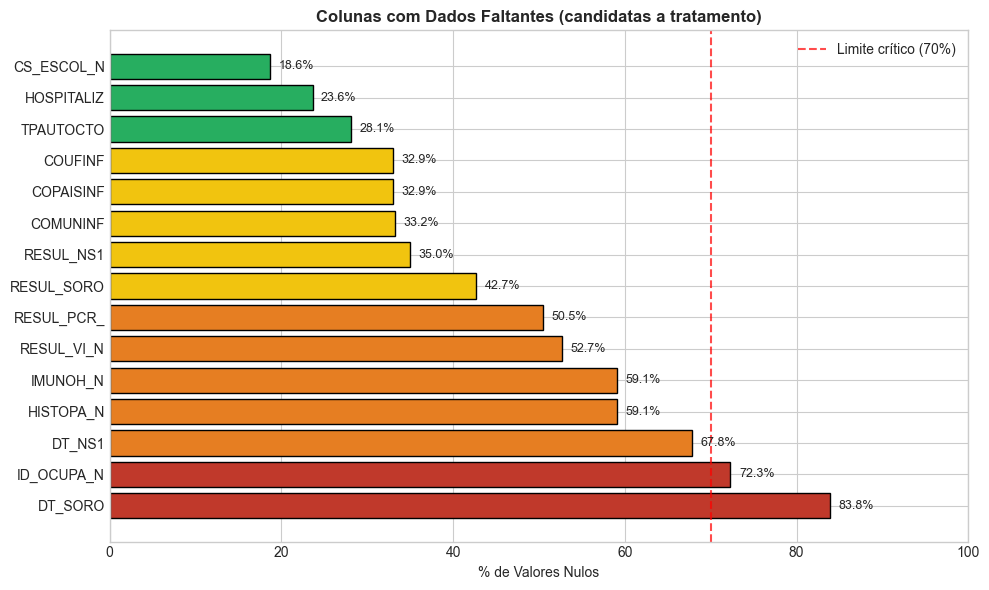

In [4]:
# Gráfico: Top 15 colunas com mais nulos (excluindo >90%)
cols_para_tratar = null_pct[(null_pct > 5) & (null_pct < 90)].head(15)

fig, ax = plt.subplots(figsize=(10, 6))

cores = ['#c0392b' if x > 70 else '#e67e22' if x > 50 else '#f1c40f' if x > 30 else '#27ae60' 
         for x in cols_para_tratar.values]

bars = ax.barh(cols_para_tratar.index, cols_para_tratar.values, color=cores, edgecolor='black')

for bar, val in zip(bars, cols_para_tratar.values):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center', fontsize=9)

ax.axvline(70, color='red', linestyle='--', alpha=0.7, label='Limite crítico (70%)')
ax.set_xlabel('% de Valores Nulos')
ax.set_title('Colunas com Dados Faltantes (candidatas a tratamento)', fontweight='bold')
ax.legend()
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()

---
## 3. Curva Epidêmica por Semana Epidemiológica

**O que mostra:** Evolução temporal dos casos para identificar picos de transmissão.

**Como interpretar:**
- 📈 Subida rápida = início de surto
- 🔝 Pico = semana com mais casos
- 📉 Queda = desaceleração da transmissão

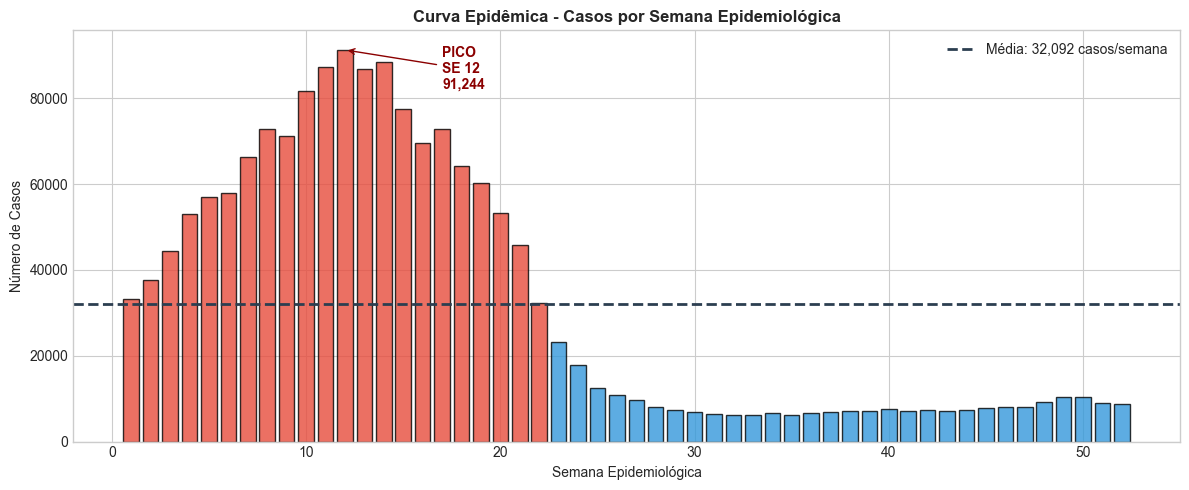


📊 RESUMO: Semana de pico = SE 12 com 91,244 casos


In [5]:
# Agrupar casos por Semana Epidemiológica
casos_se = df.groupby('SEMANA_EPI').size().sort_index()

# Identificar pico
se_pico = casos_se.idxmax()
casos_pico = casos_se.max()
media_semanal = casos_se.mean()

fig, ax = plt.subplots(figsize=(12, 5))

# Cores: vermelho se acima da média, azul se abaixo
cores = ['#e74c3c' if x > media_semanal else '#3498db' for x in casos_se.values]
ax.bar(casos_se.index, casos_se.values, color=cores, edgecolor='black', alpha=0.8)

# Linha de média
ax.axhline(media_semanal, color='#2c3e50', linestyle='--', linewidth=2, 
           label=f'Média: {media_semanal:,.0f} casos/semana')

# Marcar pico
ax.annotate(f'PICO\nSE {se_pico}\n{casos_pico:,}', xy=(se_pico, casos_pico), 
            xytext=(se_pico + 5, casos_pico * 0.9),
            fontsize=10, fontweight='bold', color='darkred',
            arrowprops=dict(arrowstyle='->', color='darkred'))

ax.set_xlabel('Semana Epidemiológica')
ax.set_ylabel('Número de Casos')
ax.set_title('Curva Epidêmica - Casos por Semana Epidemiológica', fontweight='bold', fontsize=12)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"\n📊 RESUMO: Semana de pico = SE {se_pico} com {casos_pico:,} casos")

---
## 4. Distribuição Geográfica - Incidência por UF

**O que mostra:** Taxa de casos por 100 mil habitantes em cada estado.

**Por que usar incidência (e não casos absolutos)?**  
Permite comparação justa entre estados com populações diferentes.

**Classificação de criticidade:**
| Incidência | Nível |
|------------|-------|
| >500/100k | 🔴 Muito Alta |
| 300-500/100k | 🟠 Alta |
| 100-300/100k | 🟡 Média |
| <100/100k | 🟢 Baixa |

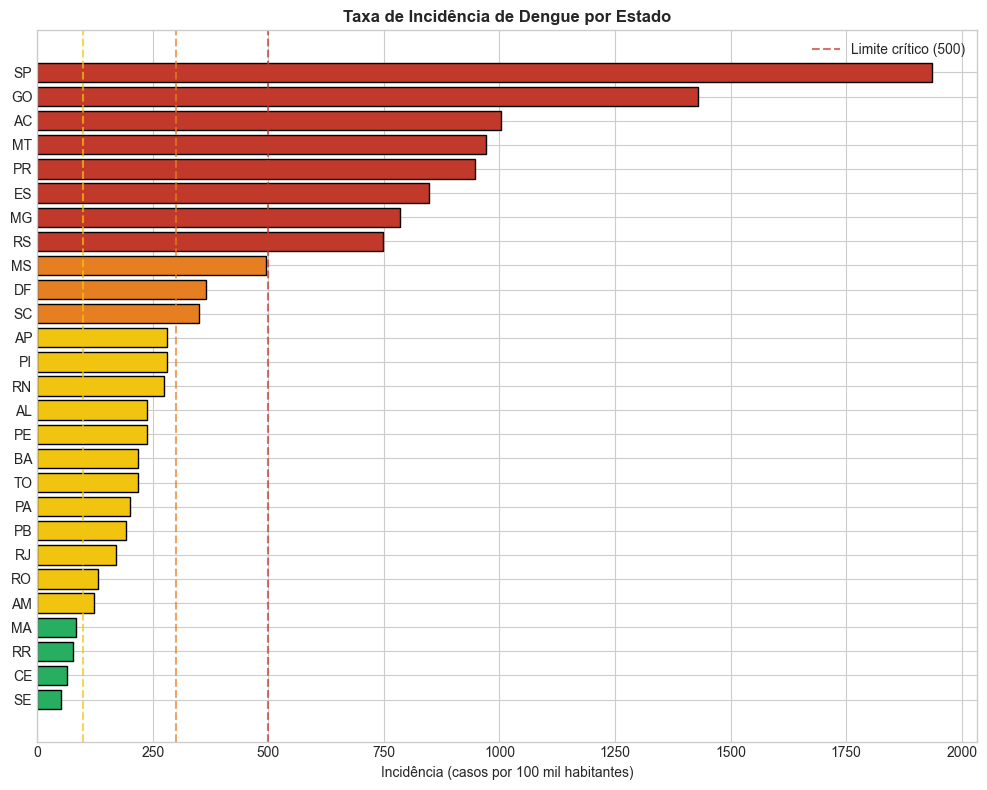

In [6]:
# Calcular incidência por UF
casos_uf = df['UF_COD'].value_counts()

incidencia_uf = []
for uf_cod, pop in UF_POPULACAO.items():
    casos = casos_uf.get(uf_cod, 0)
    incid = (casos / pop) * 100000
    nivel = '🔴 Muito Alta' if incid > 500 else '🟠 Alta' if incid > 300 else '🟡 Média' if incid > 100 else '🟢 Baixa'
    incidencia_uf.append({
        'UF': UF_MAP[uf_cod],
        'Casos': casos,
        'Populacao': pop,
        'Incidencia': incid,
        'Nivel': nivel
    })

df_uf = pd.DataFrame(incidencia_uf).sort_values('Incidencia', ascending=True)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 8))

cores = ['#c0392b' if x > 500 else '#e67e22' if x > 300 else '#f1c40f' if x > 100 else '#27ae60' 
         for x in df_uf['Incidencia']]

bars = ax.barh(df_uf['UF'], df_uf['Incidencia'], color=cores, edgecolor='black')

# Linhas de referência
ax.axvline(100, color='#f1c40f', linestyle='--', alpha=0.7)
ax.axvline(300, color='#e67e22', linestyle='--', alpha=0.7)
ax.axvline(500, color='#c0392b', linestyle='--', alpha=0.7, label='Limite crítico (500)')

ax.set_xlabel('Incidência (casos por 100 mil habitantes)')
ax.set_title('Taxa de Incidência de Dengue por Estado', fontweight='bold', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

In [7]:
# Resumo: Estados por nível de criticidade
print("📊 ESTADOS POR NÍVEL DE CRITICIDADE")
print("=" * 60)

for nivel in ['🔴 Muito Alta', '🟠 Alta', '🟡 Média', '🟢 Baixa']:
    ufs = df_uf[df_uf['Nivel'] == nivel]['UF'].tolist()
    if ufs:
        print(f"{nivel}: {', '.join(ufs)}")

print("\n🔥 TOP 5 ESTADOS MAIS AFETADOS:")
print("-" * 60)
for _, row in df_uf.nlargest(5, 'Incidencia').iterrows():
    print(f"{row['UF']}: {row['Incidencia']:.1f}/100k hab ({row['Casos']:,} casos)")

📊 ESTADOS POR NÍVEL DE CRITICIDADE
🔴 Muito Alta: RS, MG, ES, PR, MT, AC, GO, SP
🟠 Alta: SC, DF, MS
🟡 Média: AM, RO, RJ, PB, PA, TO, BA, PE, AL, RN, PI, AP
🟢 Baixa: SE, CE, RR, MA

🔥 TOP 5 ESTADOS MAIS AFETADOS:
------------------------------------------------------------
SP: 1936.6/100k hab (903,421 casos)
GO: 1429.3/100k hab (103,003 casos)
AC: 1004.1/100k hab (9,106 casos)
MT: 971.1/100k hab (35,528 casos)
PR: 946.5/100k hab (111,660 casos)


---
## 5. Gravidade Clínica

**Classificação OMS (2009):**
- **Dengue** - forma clássica (tratamento ambulatorial)
- **Dengue c/ Sinais de Alarme** - requer observação hospitalar
- **Dengue Grave** - necessita UTI

**Indicadores calculados:**
- Taxa de hospitalização = (Alarme + Grave) / Total
- Taxa de letalidade = Óbitos / Casos confirmados

In [8]:
# Classificação de gravidade
classi_map = {10: 'Dengue', 11: 'Dengue c/ Alarme', 12: 'Dengue Grave', 5: 'Descartado'}
df['GRAVIDADE'] = df['CLASSI_FIN'].map(classi_map)

# Contar por gravidade
dengue = (df['CLASSI_FIN'] == 10).sum()
alarme = (df['CLASSI_FIN'] == 11).sum()
grave = (df['CLASSI_FIN'] == 12).sum()
total_confirmado = dengue + alarme + grave

# Óbitos
obitos = (df['EVOLUCAO'] == 2).sum() if 'EVOLUCAO' in df.columns else 0

# Indicadores
taxa_hosp = ((alarme + grave) / total_confirmado * 100) if total_confirmado > 0 else 0
taxa_letal = (obitos / total_confirmado * 100) if total_confirmado > 0 else 0

print("📊 INDICADORES DE GRAVIDADE")
print("=" * 50)
print(f"Total de casos confirmados: {total_confirmado:,}")
print(f"  • Dengue (clássica): {dengue:,} ({dengue/total_confirmado*100:.1f}%)")
print(f"  • Dengue c/ Alarme: {alarme:,} ({alarme/total_confirmado*100:.1f}%)")
print(f"  • Dengue Grave: {grave:,} ({grave/total_confirmado*100:.1f}%)")
print(f"\n🏥 Taxa de hospitalização: {taxa_hosp:.2f}%")
print(f"💀 Taxa de letalidade: {taxa_letal:.3f}% ({obitos} óbitos)")

📊 INDICADORES DE GRAVIDADE
Total de casos confirmados: 1,448,318
  • Dengue (clássica): 1,411,105 (97.4%)
  • Dengue c/ Alarme: 34,577 (2.4%)
  • Dengue Grave: 2,636 (0.2%)

🏥 Taxa de hospitalização: 2.57%
💀 Taxa de letalidade: 0.122% (1773 óbitos)


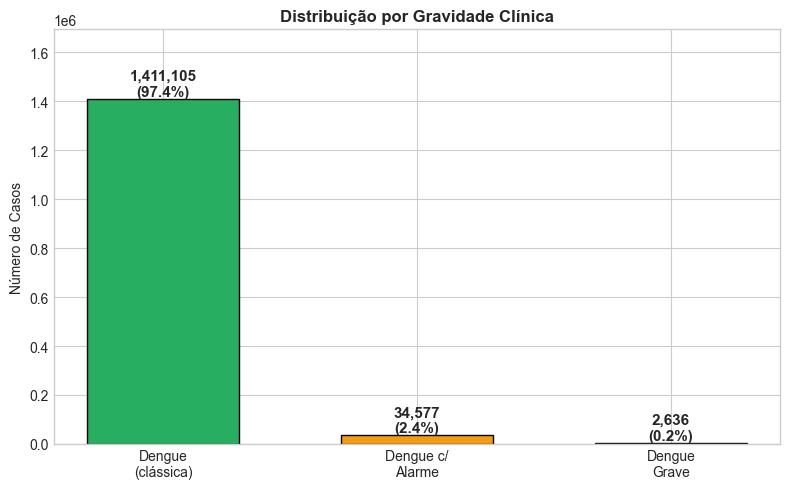

In [9]:
# Gráfico de gravidade
categorias = ['Dengue\n(clássica)', 'Dengue c/\nAlarme', 'Dengue\nGrave']
valores = [dengue, alarme, grave]
cores = ['#27ae60', '#f39c12', '#c0392b']

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(categorias, valores, color=cores, edgecolor='black', width=0.6)

for bar, val in zip(bars, valores):
    pct = val / total_confirmado * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Número de Casos')
ax.set_title('Distribuição por Gravidade Clínica', fontweight='bold', fontsize=12)
ax.set_ylim(0, max(valores) * 1.2)
plt.tight_layout()
plt.show()

### Comparativo de Letalidade por UF

**Objetivo:** Medir a eficiência do atendimento clínico nas regiões afetadas.

A taxa de letalidade é calculada como: `(Óbitos / Casos Confirmados) × 100`

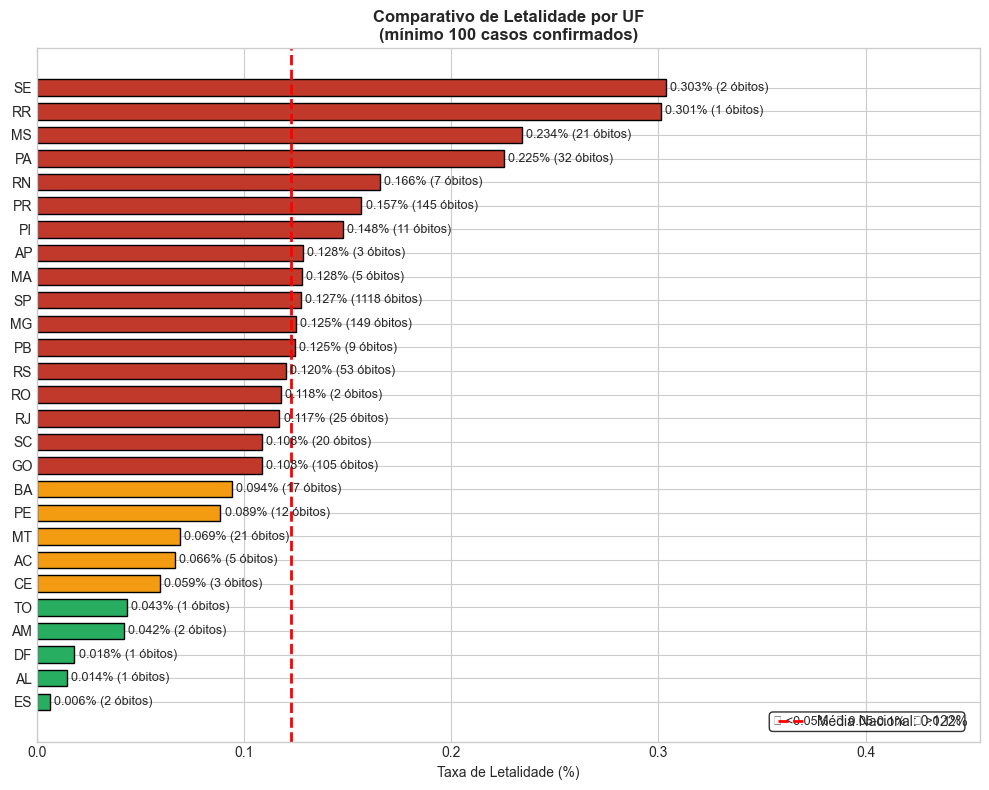


📊 RESUMO DE LETALIDADE
UF com maior letalidade: SE (0.303%)
UF com menor letalidade: ES (0.006%)
Média nacional: 0.122%


In [10]:
# Calcular letalidade por UF
letalidade_uf = []

for uf_cod, uf_nome in UF_MAP.items():
    casos_uf_total = (df['SG_UF_NOT'] == uf_cod).sum()
    obitos_uf = ((df['SG_UF_NOT'] == uf_cod) & (df['EVOLUCAO'] == 2)).sum() if 'EVOLUCAO' in df.columns else 0
    
    # Considerar apenas UFs com casos confirmados
    casos_confirmados_uf = ((df['SG_UF_NOT'] == uf_cod) & (df['CLASSI_FIN'].isin([10, 11, 12]))).sum()
    
    if casos_confirmados_uf > 0:
        taxa = (obitos_uf / casos_confirmados_uf) * 100
        letalidade_uf.append({
            'UF': uf_nome,
            'Casos': casos_confirmados_uf,
            'Óbitos': obitos_uf,
            'Letalidade': taxa
        })

# Criar DataFrame e ordenar por letalidade
df_letal = pd.DataFrame(letalidade_uf)
df_letal = df_letal[df_letal['Casos'] >= 100]  # Filtrar UFs com mínimo de 100 casos
df_letal = df_letal.sort_values('Letalidade', ascending=True)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 8))

# Cores baseadas na letalidade (verde = baixa, vermelho = alta)
cores_letal = ['#27ae60' if x < 0.05 else '#f39c12' if x < 0.1 else '#c0392b' for x in df_letal['Letalidade']]

bars = ax.barh(df_letal['UF'], df_letal['Letalidade'], color=cores_letal, edgecolor='black', height=0.7)

# Adicionar valores nas barras
for bar, row in zip(bars, df_letal.itertuples()):
    ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2, 
            f'{row.Letalidade:.3f}% ({row.Óbitos} óbitos)', 
            ha='left', va='center', fontsize=9)

# Linha de referência (média nacional)
media_nacional = (df_letal['Óbitos'].sum() / df_letal['Casos'].sum()) * 100
ax.axvline(x=media_nacional, color='red', linestyle='--', linewidth=2, label=f'Média Nacional: {media_nacional:.3f}%')

ax.set_xlabel('Taxa de Letalidade (%)')
ax.set_title('Comparativo de Letalidade por UF\n(mínimo 100 casos confirmados)', fontweight='bold', fontsize=12)
ax.legend(loc='lower right')
ax.set_xlim(0, df_letal['Letalidade'].max() * 1.5)

# Legenda de cores
ax.text(0.98, 0.02, '🟢 <0.05%  🟡 0.05-0.1%  🔴 >0.1%', 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n📊 RESUMO DE LETALIDADE")
print("=" * 50)
print(f"UF com maior letalidade: {df_letal.iloc[-1]['UF']} ({df_letal.iloc[-1]['Letalidade']:.3f}%)")
print(f"UF com menor letalidade: {df_letal.iloc[0]['UF']} ({df_letal.iloc[0]['Letalidade']:.3f}%)")
print(f"Média nacional: {media_nacional:.3f}%")

---
## 6. Perfil Demográfico

**Objetivo:** Identificar grupos mais afetados para direcionar ações de saúde.

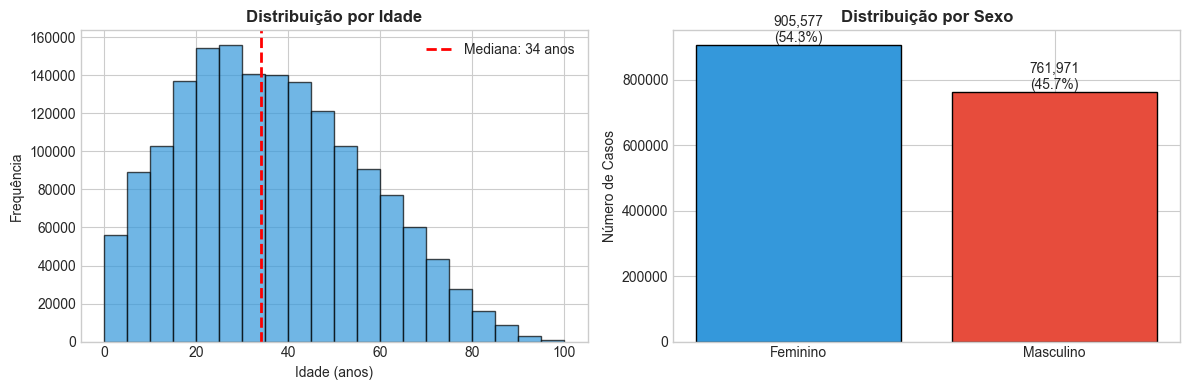

In [11]:
# Converter idade (código SINAN)
def converter_idade(cod):
    if pd.isna(cod): return None
    if cod >= 4000 and cod < 5000: return cod - 4000  # Anos
    elif cod >= 3000 and cod < 4000: return (cod - 3000) / 12  # Meses
    return None

df['IDADE_ANOS'] = df['NU_IDADE_N'].apply(converter_idade)

# Distribuição por sexo
sexo_map = {'M': 'Masculino', 'F': 'Feminino'}
sexo_counts = df['CS_SEXO'].map(sexo_map).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1: Idade
idades = df['IDADE_ANOS'].dropna()
idades = idades[idades <= 100]

axes[0].hist(idades, bins=20, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].axvline(idades.median(), color='red', linestyle='--', linewidth=2, 
                label=f'Mediana: {idades.median():.0f} anos')
axes[0].set_xlabel('Idade (anos)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição por Idade', fontweight='bold')
axes[0].legend()

# Gráfico 2: Sexo
cores_sexo = ['#3498db', '#e74c3c']
bars = axes[1].bar(sexo_counts.index, sexo_counts.values, color=cores_sexo, edgecolor='black')
for bar, val in zip(bars, sexo_counts.values):
    pct = val / sexo_counts.sum() * 100
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)
axes[1].set_ylabel('Número de Casos')
axes[1].set_title('Distribuição por Sexo', fontweight='bold')

plt.tight_layout()
plt.show()

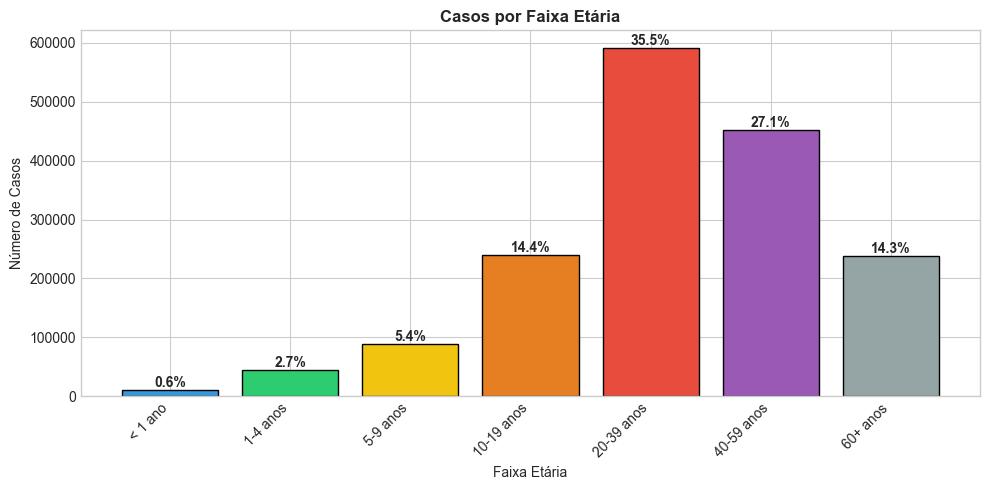


👥 Faixa etária mais afetada: 20-39 anos (591,032 casos)


In [12]:
# Faixas etárias (mesma separação do Silver)
def classificar_faixa_etaria(idade):
    if pd.isna(idade):
        return None
    elif idade < 1:
        return '< 1 ano'
    elif idade < 5:
        return '1-4 anos'
    elif idade < 10:
        return '5-9 anos'
    elif idade < 20:
        return '10-19 anos'
    elif idade < 40:
        return '20-39 anos'
    elif idade < 60:
        return '40-59 anos'
    else:
        return '60+ anos'

df['FAIXA_ETARIA'] = df['IDADE_ANOS'].apply(classificar_faixa_etaria)

# Ordenar faixas
ordem_faixas = ['< 1 ano', '1-4 anos', '5-9 anos', '10-19 anos', '20-39 anos', '40-59 anos', '60+ anos']
faixas_counts = df['FAIXA_ETARIA'].value_counts().reindex(ordem_faixas, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 5))

cores_faixa = ['#3498db', '#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#9b59b6', '#95a5a6']
bars = ax.bar(faixas_counts.index, faixas_counts.values, color=cores_faixa, edgecolor='black')

for bar, val in zip(bars, faixas_counts.values):
    pct = val / faixas_counts.sum() * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Faixa Etária')
ax.set_ylabel('Número de Casos')
ax.set_title('Casos por Faixa Etária', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

faixa_mais_afetada = faixas_counts.idxmax()
print(f"\n👥 Faixa etária mais afetada: {faixa_mais_afetada} ({faixas_counts.max():,} casos)")

---
## 7. Conclusões e Recomendações

In [13]:
# Gerar relatório final
ufs_criticas = df_uf[df_uf['Incidencia'] > 500]['UF'].tolist()
ufs_altas = df_uf[(df_uf['Incidencia'] > 300) & (df_uf['Incidencia'] <= 500)]['UF'].tolist()

print("""
╔══════════════════════════════════════════════════════════════════╗
║           RELATÓRIO DE ANÁLISE EPIDEMIOLÓGICA                   ║
║                    DENGUE - SINAN 2024-2025                     ║
╚══════════════════════════════════════════════════════════════════╝
""")

print(f"📊 RESUMO GERAL")
print(f"   • Total de notificações: {len(df):,}")
print(f"   • Casos confirmados: {total_confirmado:,}")
print(f"   • Semana de pico: SE {se_pico} ({casos_pico:,} casos)")
print(f"   • Taxa de letalidade: {taxa_letal:.3f}%")

print(f"\n🗺️ SITUAÇÃO GEOGRÁFICA")
print(f"   • UFs em criticidade MUITO ALTA: {', '.join(ufs_criticas) if ufs_criticas else 'Nenhuma'}")
print(f"   • UFs em criticidade ALTA: {', '.join(ufs_altas) if ufs_altas else 'Nenhuma'}")

print(f"\n📋 QUALIDADE DOS DADOS")
print(f"   • Colunas para excluir (>90% nulos): {len(cols_criticas)}")
print(f"   • Colunas para tratar: {len(cols_altas) + len(cols_medias)}")

print("""
═══════════════════════════════════════════════════════════════════
🎯 RECOMENDAÇÕES PRIORITÁRIAS
═══════════════════════════════════════════════════════════════════

1. CONTROLE VETORIAL
   • Intensificar nebulização nas UFs críticas
   • Mutirões de limpeza antes da SE de pico

2. ASSISTÊNCIA À SAÚDE
   • Preparar leitos de observação (formas com alarme)
   • Capacitar equipes para manejo clínico

3. VIGILÂNCIA
   • Monitorar SE semanalmente
   • Investigar óbitos em 48h

═══════════════════════════════════════════════════════════════════
📁 PRÓXIMA ETAPA: Processar dados na camada SILVER
═══════════════════════════════════════════════════════════════════
""")


╔══════════════════════════════════════════════════════════════════╗
║           RELATÓRIO DE ANÁLISE EPIDEMIOLÓGICA                   ║
║                    DENGUE - SINAN 2024-2025                     ║
╚══════════════════════════════════════════════════════════════════╝

📊 RESUMO GERAL
   • Total de notificações: 1,668,787
   • Casos confirmados: 1,448,318
   • Semana de pico: SE 12 (91,244 casos)
   • Taxa de letalidade: 0.122%

🗺️ SITUAÇÃO GEOGRÁFICA
   • UFs em criticidade MUITO ALTA: RS, MG, ES, PR, MT, AC, GO, SP
   • UFs em criticidade ALTA: SC, DF, MS

📋 QUALIDADE DOS DADOS
   • Colunas para excluir (>90% nulos): 57
   • Colunas para tratar: 12

═══════════════════════════════════════════════════════════════════
🎯 RECOMENDAÇÕES PRIORITÁRIAS
═══════════════════════════════════════════════════════════════════

1. CONTROLE VETORIAL
   • Intensificar nebulização nas UFs críticas
   • Mutirões de limpeza antes da SE de pico

2. ASSISTÊNCIA À SAÚDE
   • Preparar leitos de observaç